# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import helpers
from slam import get_residual, get_my_jacob, get_jax_jacob, calc_init_poses, LM


## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

Estimate using odometry


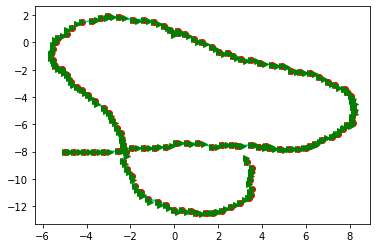

In [2]:

EDGES_FILE = '../data/edges.txt'
EDGES_POSES_FILE = '../data/edges-poses.g2o'

nodes, edges = helpers.read_data(EDGES_FILE)
fixed = nodes[:, 0]
poses = calc_init_poses(fixed, edges)
print("Estimate using odometry")
helpers.draw_one(poses[:, 0], poses[:, 1], poses[:, 2])
helpers.write_edges_poses(EDGES_POSES_FILE, EDGES_FILE, poses)


## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

Comparing Jacobians
Frobenius norm between my jacobian and jax jacobian is: 0.0


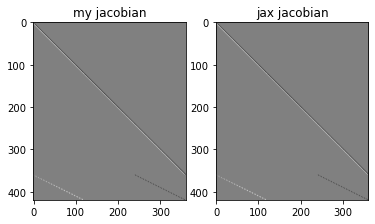

In [3]:
def compare_jacobs():
    my_jacob = get_my_jacob(poses, edges, fixed)
    jax_jacob = get_jax_jacob(poses, edges, fixed)

    print("Comparing Jacobians")
    helpers.frobNorm(my_jacob, jax_jacob, "my jacobian", "jax jacobian")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(my_jacob, cmap='gray')
    ax[1].imshow(jax_jacob, cmap='gray')
    ax[0].set_title('my jacobian')
    ax[1].set_title('jax jacobian')
    plt.show()

compare_jacobs()


Using Weights: (5, 12.5, 20)

Iteration 0: Error: 11417.35546875


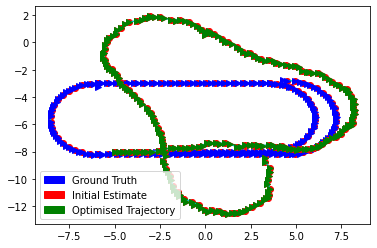

Iteration 1: Error: 1683.0321044921875
Iteration 2: Error: 81.50809478759766
Iteration 3: Error: 43.227664947509766
Iteration 4: Error: 41.769927978515625
Iteration 5: Error: 40.524898529052734


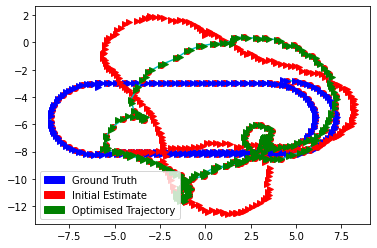

Iteration 6: Error: 40.96844482421875
Iteration 7: Error: 40.627281188964844
Iteration 8: Error: 42.79487609863281
Iteration 9: Error: 42.08644104003906
Iteration 10: Error: 50.2699089050293


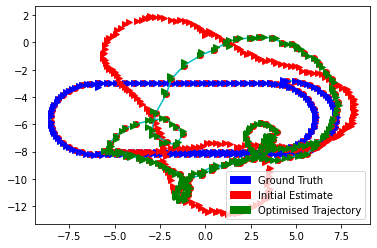

Iteration 11: Error: 41.57538604736328
Iteration 12: Error: 46.540924072265625
Iteration 13: Error: 38.81394577026367
Iteration 14: Error: 39.76784896850586
Iteration 15: Error: 37.41543197631836


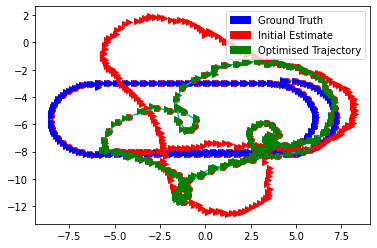

Iteration 16: Error: 38.46800994873047
Iteration 17: Error: 37.64870834350586
Iteration 18: Error: 38.74398422241211
Iteration 19: Error: 37.94196319580078
Iteration 20: Error: 37.28939437866211


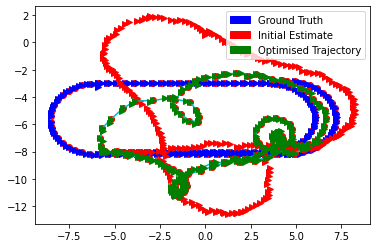

Iteration 21: Error: 35.95301055908203
Iteration 22: Error: 35.05509948730469
Iteration 23: Error: 33.813167572021484
Iteration 24: Error: 33.33937072753906
Iteration 25: Error: 32.60333251953125


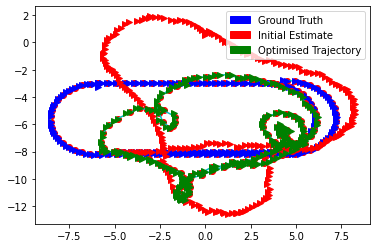

Iteration 26: Error: 32.332149505615234
Iteration 27: Error: 31.947628021240234
Iteration 28: Error: 31.748348236083984
Iteration 29: Error: 31.490217208862305
Iteration 30: Error: 31.286394119262695


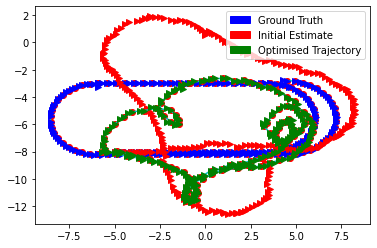

Iteration 31: Error: 31.054460525512695
Iteration 32: Error: 30.867713928222656
Iteration 33: Error: 30.72309112548828
Iteration 34: Error: 30.642318725585938
Iteration 35: Error: 30.59784507751465


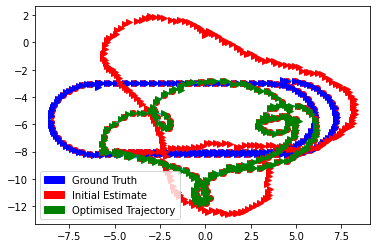

Iteration 36: Error: 30.57576560974121
Iteration 37: Error: 30.563343048095703
Iteration 38: Error: 30.556840896606445
Iteration 39: Error: 30.553016662597656
Iteration 40: Error: 30.550939559936523


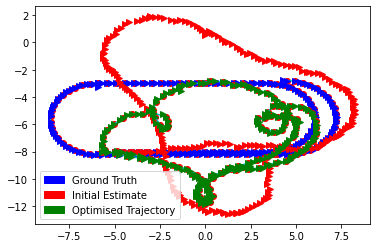

Iteration 41: Error: 30.549684524536133
Iteration 42: Error: 30.549001693725586
Iteration 43: Error: 30.548583984375
Iteration 44: Error: 30.548341751098633
Iteration 45: Error: 30.548200607299805


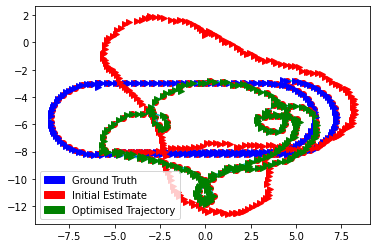

Iteration 46: Error: 30.548126220703125
Iteration 47: Error: 30.548053741455078
Iteration 48: Error: 30.548015594482422
Iteration 49: Error: 30.54801368713379
Iteration 50: Error: 30.548017501831055


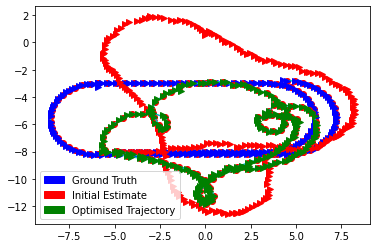

Iteration 51: Error: 30.54798126220703
Iteration 52: Error: 30.547992706298828
Iteration 53: Error: 30.54799461364746
Iteration 54: Error: 30.547992706298828
Iteration 55: Error: 30.547998428344727


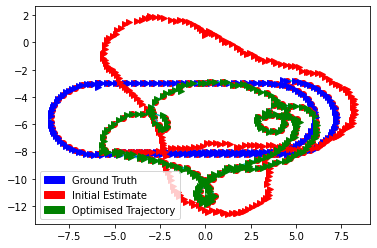

Iteration 56: Error: 30.54800033569336
Iteration 57: Error: 30.54799461364746
Iteration 58: Error: 30.547988891601562
Iteration 59: Error: 30.547998428344727
Iteration 60: Error: 30.547996520996094


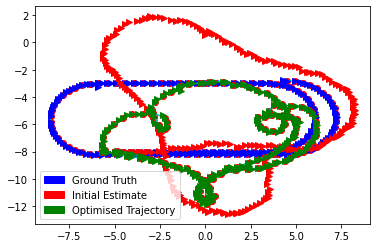

Final Error: 30.547992706298828 at itr: 61


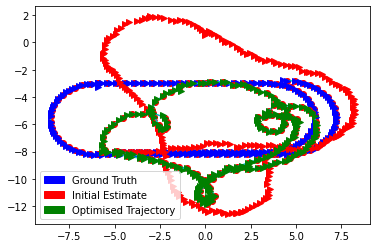

In [4]:
lm = LM(poses,edges, fixed, 0.01, 61, 1e-6, [2.5,4])
poses_arr, error_arr = lm.optimize()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.